In [1]:
from astropy.table import Table
from astropy.io import fits

import numpy as np

import sys

import matplotlib
import matplotlib.pyplot as plt

from functions import *

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import skewnorm

np.set_printoptions(threshold=sys.maxsize)

In [2]:
matplotlib.rcParams['text.usetex']=True
matplotlib.rc('font', size=18)
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='DejaVu Sans')

# Data

In [3]:
data_filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits'

# data_old = Table.read('data_flags_updated_Oct8.dat', format = 'ascii')
#data = Table.read('data_flags_updated_Nov1.dat', format = 'ascii')
#print(len(data))
#catalog =data
hdu = fits.open(data_filename)
data = Table(hdu[1].data)
hdu.close()

## Just keep the main SDSS DR7 footprint

In [4]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

In [5]:
# ra,dec,z
ra = np.array(catalog_main['RA'])
dec = np.array(catalog_main['DEC'])
z = np.array(catalog_main['Z'])

#stellar mass
#Mstar = np.array(data['Mstar'])
Mstar_NSA = np.log10(catalog_main['ELPETRO_MASS'])

# color
#u_r = np.array(data['u_r'])
# u_r = u_r[np.logical_not(np.isnan(u_r))] 
u_r_NSA = np.array(catalog_main['u_r'])

#g_r = np.array(data['g_r'])
g_r_NSA = np.array(catalog_main['g_r'])

# absolute magnitude
#rabsmag = np.array(data['rabsmag'])
rabsmag_NSA = np.array(catalog_main['ELPETRO_ABSMAG'][:,4])

# star formation rate and specific SPR
#SFR = np.array(data['SFR'])
SFR  = np.array(catalog_main['SFR'])

#sSFR = np.array(data['sSFR'])
sSFR = np.array(catalog_main['sSFR'])

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_1837/3799946246.py:8: RuntimeWarning: divide by zero encountered in log10
  Mstar_NSA = np.log10(catalog_main['ELPETRO_MASS'])


## Separate galaxies by their LSS classifications

### $V^2$

In [6]:
wall_v2 = catalog_main['vflag_V2'] == 0 #np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = catalog_main['vflag_V2'] == 1 #np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = catalog_main['vflag_V2'] == 2 #np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = catalog_main['vflag_V2'] == 9 #np.argwhere(data['flag_vsquared'] == 9).flatten()

### VoidFinder

In [7]:
wall_vf = catalog_main['vflag_VF'] == 0 #np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = catalog_main['vflag_VF'] == 1 #np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = catalog_main['vflag_VF'] == 2 #np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = catalog_main['vflag_VF'] == 9 #np.argwhere(data['flag_voidfinder'] == 9).flatten()

# Fit the distributions with skewnormal distributions

In [9]:
def func_bimodal(x, a, mua, sga, askew, b, mub, sgb, bskew):
    '''returns a mixture of two skewnormal distributions'''
    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) + b*skewnorm.pdf(x, bskew, loc=mub, scale=sgb)

def func_unimodal(x, a, mua, sga, askew):
    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) 

In [13]:
def bin_data(data, bins_, label="label me", plot=False): 

    n1, edges1 = np.histogram(data, bins=bins_)
    dn1 = np.sqrt(n1)
    x = 0.5*(edges1[1:] + edges1[:-1])
        
    if plot:
        plt.errorbar(x, n1, yerr=dn1, fmt='.')        
        plt.xlabel(label, fontsize=18)
        plt.ylabel('count',fontsize=18) 
        plt.title(label)
        plt.show()
        
    return  x,n1,dn1 #, popt_void

In [14]:
def fit_bimodal(char_, class_, bins, p0_=None, err=None, label=''):
    
    x_data, y_data, dy = bin_data(data=char_[class_], bins_=bins)   
    
    err[np.argwhere(err==0)] = 0.00001
    
    #s = dy
    
    popt_, pcov_ = curve_fit(func_bimodal, x_data, y_data, p0=p0_)#, sigma=s)#, sigma=cov)
    
    ############################################################################
    # Plot distribution and best fit
    #---------------------------------------------------------------------------
    plt.errorbar(x_data, y_data, yerr=err, fmt='.')  
    plt.plot(x_data, func_bimodal(x_data, *popt_), 'k')
    plt.ylabel('Counts')
    plt.title(label)
    plt.show()
    ############################################################################
    
    print(popt_, np.sqrt(np.diag(pcov_)))
    
    return popt_, np.sqrt(np.diag(pcov_))

In [15]:
def fit_unimodal(char_, class_, bins, p0_=None, err=None, label=''):
    
    x_data,y_data,dy=bin_data(data=char_[class_],bins_=bins)
    
    err[np.argwhere(err==0)]= 0.00001
    
    s=dy
    
    popt_, pcov_ = curve_fit(func_unimodal, x_data, y_data,p0=p0_)#, sigma=s)#, sigma=cov)
    
    ############################################################################
    # Plot distribution and best fit
    #---------------------------------------------------------------------------
    plt.errorbar(x_data, y_data, yerr=err, fmt='.')  
    plt.plot(x_data, func_unimodal(x_data, *popt_), 'k') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
    plt.ylabel("Counts")
    plt.title(label)
    plt.show()
    ############################################################################
    
    print(popt_, np.sqrt(np.diag(pcov_)))
    
    return popt_, np.sqrt(np.diag(pcov_))
    

## $M_*$ mean

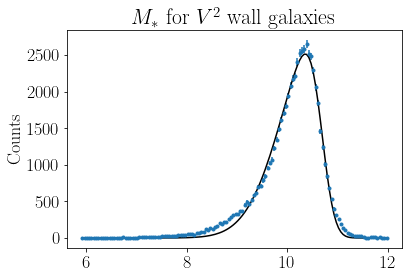

[ 2.73153184e+03  1.06840086e+01  7.42128864e-01 -3.58838774e+00] [2.09746774e+01 5.07321883e-03 9.16482910e-03 1.53865064e-01]


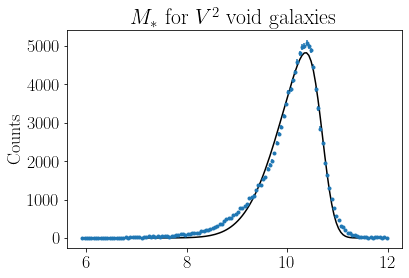

[ 5.21234588e+03  1.06874098e+01  7.42294865e-01 -3.68562475e+00] [4.54464990e+01 5.62830751e-03 1.02967169e-02 1.79217744e-01]


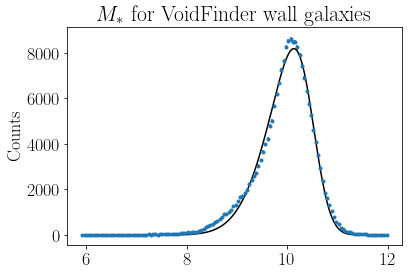

[ 9.21701165e+03  1.04895315e+01  7.01799438e-01 -2.39720642e+00] [6.86392627e+01 7.21204876e-03 1.04231593e-02 1.10629143e-01]


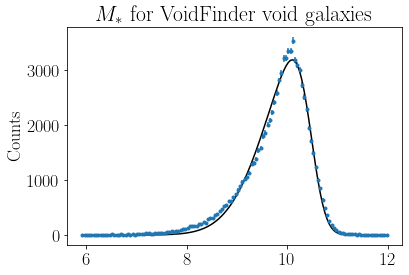

[ 3.80842883e+03  1.04643220e+01  8.09402416e-01 -3.40841258e+00] [2.95046348e+01 5.85058317e-03 1.03084888e-02 1.48039050e-01]


In [17]:
#print("wall_v2")
k = bin_data(Mstar_NSA[wall_v2], bins_=np.linspace(5.9,12, 135))
x, poiss_err = k[0], k[2]
Mstar_NSA_V2_wall_fit = fit_unimodal(char_=Mstar_NSA,
                                     class_=wall_v2,
                                     bins=np.linspace(5.9,12, 135), 
                                     err=poiss_err,
                                     p0_=[ 2000,  10.5,  1.3, 1], 
                                     label='$M_*$ for $V^2$ wall galaxies')


#print("\n void_v2")
k = bin_data(Mstar_NSA[void_v2], bins_=np.linspace(5.9,12, 135))
x, poiss_err = k[0], k[2]
Mstar_NSA_V2_void_fit = fit_unimodal(char_=Mstar_NSA, 
                                     class_=void_v2,
                                     bins=np.linspace(5.9,12, 135), 
                                     err=poiss_err,
                                     p0_=[ 2000,  10.5,  1.3, 1], 
                                     label='$M_*$ for $V^2$ void galaxies')


#print("\n wall_vf")
k = bin_data(Mstar_NSA[wall_vf], bins_=np.linspace(5.9,12, 135))
x, poiss_err = k[0], k[2]
Mstar_NSA_VF_wall = fit_unimodal(char_=Mstar_NSA,
                                 class_=wall_vf,
                                 bins=np.linspace(5.9,12, 135), 
                                 err=poiss_err,
                                 p0_=[ 2000,  10.5,  1.3, 1], 
                                 label='$M_*$ for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(Mstar_NSA[void_vf], bins_=np.linspace(5.9,12, 135))
x, poiss_err = k[0], k[2]
Mstar_NSA_VF_void = fit_unimodal(char_=Mstar_NSA,
                                 class_=void_vf,
                                 bins=np.linspace(5.9,12, 135), 
                                 err=poiss_err,
                                 p0_=[ 2000,  10.5,  1.3, 1], 
                                 label='$M_*$ for VoidFinder void galaxies')

## $M_r$ mean 

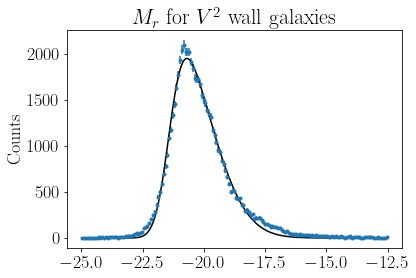

[ 4.45815532e+03 -2.13976655e+01  1.52395005e+00  3.17549413e+00] [2.87558126e+01 9.82105118e-03 1.66954997e-02 1.15913439e-01]


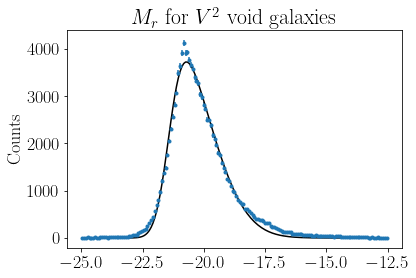

[ 8.52046600e+03 -2.14125944e+01  1.53559446e+00  3.28360490e+00] [5.71278996e+01 9.95354880e-03 1.72132890e-02 1.23962640e-01]


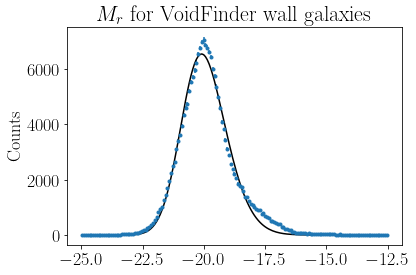

[ 1.48372674e+04 -2.07609816e+01  1.23831838e+00  1.49834057e+00] [1.19442858e+02 2.88280380e-02 2.94031025e-02 1.11083023e-01]


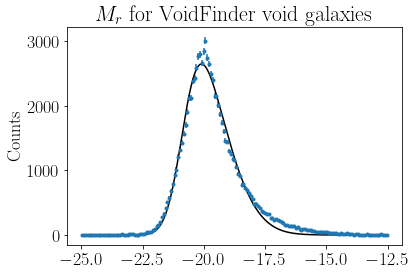

[ 6.10638340e+03 -2.08252247e+01  1.43860231e+00  2.41436257e+00] [4.96568406e+01 1.59934569e-02 2.32207236e-02 1.21247347e-01]


In [19]:
#print("wall_v2")
k = bin_data(rabsmag_NSA[wall_v2], bins_=np.linspace(-25,-12.5, 170))
x, poiss_err = k[0], k[2]
rabsmag_NSA_V2_wall_fit = fit_unimodal(char_=rabsmag_NSA,
                                       class_=wall_v2,
                                       bins=np.linspace(-25,-12.5, 170), 
                                       err=poiss_err,p0_=[ 2000,  -20,  1.3, 1], 
                                       label='$M_r$ for $V^2$ wall galaxies')


#print("\n void_v2")
k = bin_data(rabsmag_NSA[void_v2], bins_=np.linspace(-25,-12.5, 170))
x, poiss_err = k[0], k[2]
rabsmag_NSA_V2_void_fit = fit_unimodal(char_=rabsmag_NSA,
                                       class_=void_v2,
                                       bins=np.linspace(-25,-12.5, 170), 
                                       err=poiss_err,p0_=[ 2000,  -20,  1.3, 1], 
                                       label='$M_r$ for $V^2$ void galaxies')


#print("\n wall_vf")
k = bin_data(rabsmag_NSA[wall_vf], bins_=np.linspace(-25,-12.5, 170))
x, poiss_err = k[0], k[2]
rabsmag_NSA_VF_wall_fit = fit_unimodal(char_=rabsmag_NSA,
                                       class_=wall_vf,
                                       bins=np.linspace(-25,-12.5, 170), 
                                       err=poiss_err,p0_=[ 2000,  -20,  1.3, 1], 
                                       label='$M_r$ for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(rabsmag_NSA[void_vf], bins_=np.linspace(-25,-12.5, 170))
x, poiss_err = k[0], k[2]
rabsmag_NSA_VF_void_fit = fit_unimodal(char_=rabsmag_NSA,
                                       class_=void_vf,
                                       bins=np.linspace(-25,-12.5, 170), 
                                       err=poiss_err,p0_=[ 2000,  -20,  1.3, 1], 
                                       label='$M_r$ for VoidFinder void galaxies')

## $u-r$ mean

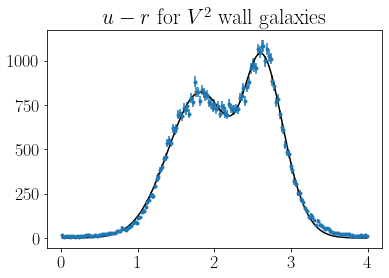

[ 8.68864672e+02  1.81884050e+00  4.21343846e-01 -4.14721434e-03
  5.92268623e+02  2.45328342e+00  3.55461038e-01  1.51777145e+00] [1.78232734e+01 7.83214285e+02 2.58680114e+00 2.32977955e+03
 1.65604151e+01 8.46544221e-03 8.83277585e-03 1.47145427e-01]


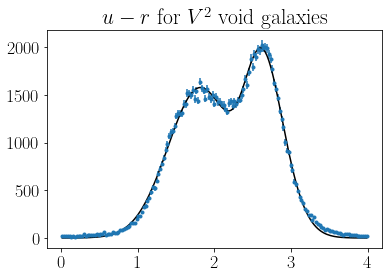

[ 1.13630846e+03  2.45996930e+00  3.45823578e-01  1.37390748e+00
  1.66696548e+03  1.81376497e+00  4.21728639e-01 -3.67216727e-04] [2.27074652e+01 7.98938312e-03 7.87888239e-03 1.23886834e-01
 2.56307891e+01 8.14471869e+01 3.38998124e-02 2.42050144e+02]


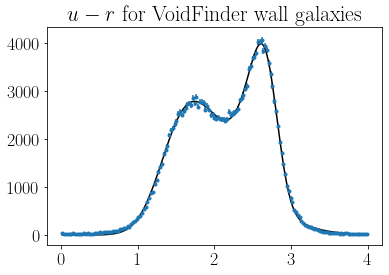

[ 1.54416265e+03  2.78584428e+00  2.83922200e-01 -1.68822891e+00
  3.35938491e+03  1.35329884e+00  7.75430109e-01  2.67728478e+00] [2.16078817e+01 3.78960682e-03 5.05403981e-03 7.99968559e-02
 2.79591104e+01 4.24745180e-03 1.00166902e-02 7.47432941e-02]


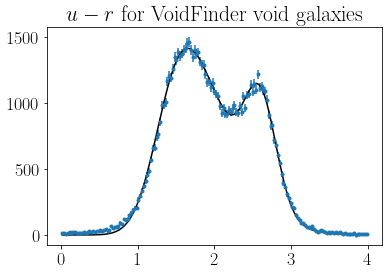

[1.58696222e+03 1.29555504e+00 7.02366369e-01 2.45966920e+00
 4.23458949e+02 2.54011077e+00 2.17901646e-01 3.68961387e-01] [2.07771160e+01 6.91270810e-03 1.87791570e-02 1.26852286e-01
 1.83551026e+01 1.24619408e-01 3.59347075e-02 8.25811657e-01]


In [20]:
# a, mua, sga, askew, b, mub, sgb, bskew

#print("wall_v2")
k = bin_data(u_r_NSA[wall_v2], bins_=np.linspace(0,4, 170))
x, poiss_err = k[0], k[2]
ur_NSA_V2_wall_fit = fit_bimodal(char_=u_r_NSA,
                                 class_=wall_v2,
                                 bins=np.linspace(0,4, 170), 
                                 err=poiss_err, 
                                 label='$u-r$ for $V^2$ wall galaxies')#,p0_=[ 2000,  1.5,  1.3, 1,2000,2.7,1,1])


#print("\n void_v2")
k = bin_data(u_r_NSA[void_v2], bins_=np.linspace(0,4, 170))
x, poiss_err = k[0], k[2]
ur_NSA_V2_void_fit = fit_bimodal(char_=u_r_NSA,
                                 class_=void_v2,
                                 bins=np.linspace(0,4, 170), 
                                 err=poiss_err, 
                                 label='$u-r$ for $V^2$ void galaxies')


#print("\n wall_vf")
k = bin_data(u_r_NSA[wall_vf], bins_=np.linspace(0,4, 170))
x, poiss_err = k[0], k[2]
ur_NSA_VF_wall_fit = fit_bimodal(char_=u_r_NSA,
                                 class_=wall_vf,
                                 bins=np.linspace(0,4, 170), 
                                 err=poiss_err, 
                                 label='$u-r$ for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(u_r_NSA[void_vf], bins_=np.linspace(0,4, 170))
x, poiss_err = k[0], k[2]
ur_NSA_VF_void_fit = fit_bimodal(char_=u_r_NSA,
                                 class_=void_vf,
                                 bins=np.linspace(0,4, 170), 
                                 err=poiss_err,
                                 p0_=[2000,  1.5,  1.3, 1, 2000, 2.7, 1, 1], 
                                 label='$u-r$ for VoidFinder void galaxies')

## $g-r$ means

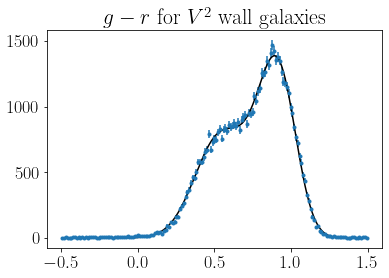

[ 3.07723629e+02  5.32419090e-01  1.63099008e-01 -5.82092920e-03
  4.34650142e+02  9.96227438e-01  1.73133849e-01 -1.34525051e+00] [2.27133852e+01 2.83076542e+02 9.89086696e-01 2.17538109e+03
 2.21372506e+01 7.84246578e-03 1.48610593e-02 2.40436160e-01]


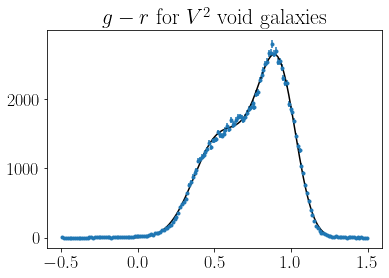

[ 7.71256814e+02  9.99765304e-01  1.72672199e-01 -1.38389936e+00
  6.52246512e+02  4.08876724e-01  2.38714762e-01  1.30444334e+00] [1.22420524e+02 6.07658630e-03 1.75569041e-02 2.16238570e-01
 1.23493531e+02 3.44993760e-02 7.62081154e-02 8.00734770e-01]


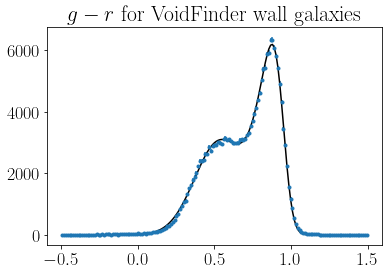

[ 1.23512020e+03  9.46239652e-01  1.33721927e-01 -2.60013109e+00
  1.22718381e+03  5.32320222e-01  1.61876760e-01  2.88284662e-04] [1.77970603e+01 7.14861856e-04 2.27537840e-03 7.93527449e-02
 1.95710398e+01 9.84631065e+00 2.72301947e-03 7.62315598e+01]


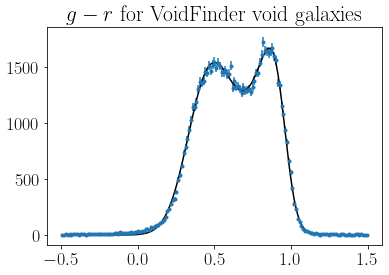

[ 3.55552175e+02  9.52877972e-01  1.55263914e-01 -2.31959977e+00
  6.59678429e+02  3.57750967e-01  2.47140820e-01  1.73433942e+00] [2.14710914e+01 2.06017603e-03 6.48089784e-03 1.39488386e-01
 2.25811089e+01 5.88889768e-03 1.47936957e-02 1.84110946e-01]


In [21]:
# a, mua, sga, askew, b, mub, sgb, bskew

#print("wall_v2")
k = bin_data(g_r_NSA[wall_v2], bins_=np.linspace(-0.5,1.5, 170))
x, poiss_err = k[0], k[2]
gr_NSA_V2_wall_fit = fit_bimodal(char_=g_r_NSA,
                                 class_=wall_v2,
                                 bins=np.linspace(-0.5,1.5, 170), 
                                 err=poiss_err, 
                                 label='$g-r$ for $V^2$ wall galaxies')#,p0_=[ 2000,  1.5,  1.3, 1,2000,2.7,1,1])


#print("\n void_v2")
k = bin_data(g_r_NSA[void_v2], bins_=np.linspace(-0.5,1.5, 170))
x, poiss_err = k[0], k[2]
gr_NSA_V2_void_fit = fit_bimodal(char_=g_r_NSA,
                                 class_=void_v2,
                                 bins=np.linspace(-0.5,1.5, 170), 
                                 err=poiss_err, 
                                 label='$g-r$ for $V^2$ void galaxies')


#print("\n wall_vf")
k = bin_data(g_r_NSA[wall_vf], bins_=np.linspace(-0.5,1.5, 170))
x, poiss_err = k[0], k[2]
gr_NSA_VF_wall_fit = fit_bimodal(char_=g_r_NSA, 
                                 class_=wall_vf,
                                 bins=np.linspace(-0.5,1.5, 170), 
                                 err=poiss_err, 
                                 label='$g-r$ for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(g_r_NSA[void_vf], bins_=np.linspace(-0.5,1.5, 170))
x, poiss_err = k[0], k[2]
gr_NSA_VF_void_fit = fit_bimodal(char_=g_r_NSA,
                                 class_=void_vf,
                                 bins=np.linspace(-0.5,1.5, 170), 
                                 err=poiss_err,
                                 p0_=np.array([ 8.85731778e+02,  9.84204392e-01,  8.07998114e-02, -3.33639653e+00, 1.39274659e+03,  4.75774665e-01,  2.82524710e-01,  1.32105068e+00]), 
                                 label='$g-r$ for VoidFinder void galaxies')

## SFR

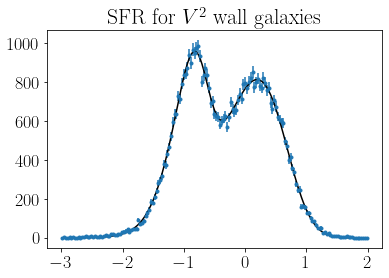

[ 5.02294614e+02 -6.45674759e-01  4.36925522e-01 -2.20675160e+00
  1.15537963e+03  6.43918213e-01  9.00759895e-01 -2.58386658e+00] [2.23729359e+01 7.29246399e-03 1.19190461e-02 1.31952129e-01
 2.41722305e+01 1.17914677e-02 3.68572068e-02 1.92309177e-01]


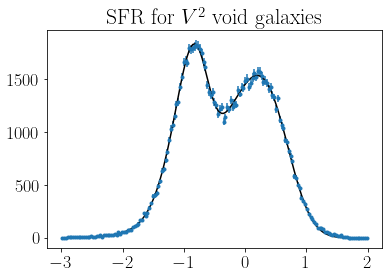

[ 8.86447525e+02 -6.60129174e-01  4.07903094e-01 -1.95166787e+00
  2.28831382e+03  6.63574791e-01  9.70863994e-01 -2.87574265e+00] [2.30920633e+01 5.82852673e-03 8.95886154e-03 9.78693319e-02
 2.66380865e+01 6.05226621e-03 2.01067169e-02 1.10741082e-01]


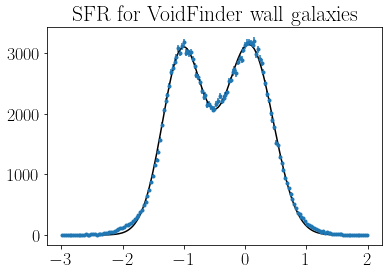

[ 2.40714243e+03 -1.03389025e+00  3.26366266e-01  2.33201644e-03
  3.21030252e+03  3.36321533e-01  5.18235084e-01 -1.15945602e+00] [5.47947256e+01 3.09154567e+02 7.52721757e-01 1.18722922e+03
 5.16417252e+01 2.66866700e-02 3.07023499e-02 1.80384580e-01]


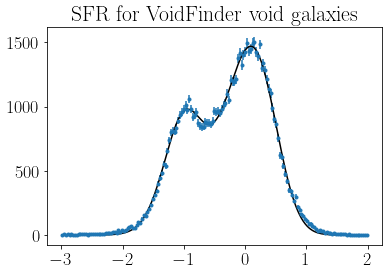

[ 6.26687805e+02 -8.28947524e-01  3.81249067e-01 -9.79443696e-01
  1.63966033e+03  4.40641852e-01  6.48529625e-01 -1.86026119e+00] [4.76826190e+01 3.11000444e-02 2.21429782e-02 2.95069907e-01
 4.78641610e+01 1.96508385e-02 4.40757394e-02 2.39937103e-01]


In [23]:
# a, mua, sga, askew, b, mub, sgb, bskew

#print("wall_v2")
k = bin_data(SFR[wall_v2], bins_=np.linspace(-3,2, 170))
x, poiss_err = k[0], k[2]
SFR_V2_wall_fit = fit_bimodal(char_=SFR,
                              class_=wall_v2,
                              bins=np.linspace(-3,2, 170), 
                              err=poiss_err, 
                              label='SFR for $V^2$ wall galaxies')#,p0_=[ 2000,  1.5,  1.3, 1,2000,2.7,1,1])


#print("\n void_v2")
k = bin_data(SFR[void_v2], bins_=np.linspace(-3,2, 170))
x, poiss_err = k[0], k[2]
SFR_V2_void_fit = fit_bimodal(char_=SFR,
                              class_=void_v2,
                              bins=np.linspace(-3,2, 170), 
                              err=poiss_err, 
                              label='SFR for $V^2$ void galaxies')


#print("\n wall_vf")
k = bin_data(SFR[wall_vf], bins_=np.linspace(-3,2, 170))
x, poiss_err = k[0], k[2]
SFR_VF_wall_fit = fit_bimodal(char_=SFR,
                              class_=wall_vf,
                              bins=np.linspace(-3,2, 170), 
                              err=poiss_err, 
                              p0_=[2000, -1.5, 1.3, 1, 2000, 0.7, 1, 1], 
                              label='SFR for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(SFR[void_vf], bins_=np.linspace(-3,2, 170))
x, poiss_err = k[0], k[2]
SFR_VF_void_fit = fit_bimodal(char_=SFR,
                              class_=void_vf,
                              bins=np.linspace(-3,2, 170), 
                              err=poiss_err,
                              p0_=[2000,  -1.5,  1.3, 1, 2000, 0.7, 1, 1], 
                              label='SFR for VoidFinder void galaxies')

## sSFR means

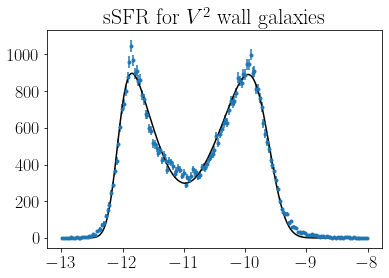

[ 9.57215477e+02 -9.62135569e+00  7.18296922e-01 -3.22063166e+00
  6.83822587e+02 -1.20795621e+01  5.30770065e-01  3.78499827e+00] [1.31718558e+01 7.95876587e-03 1.94023161e-02 2.17539406e-01
 1.22834463e+01 5.52443076e-03 1.48975430e-02 2.74434528e-01]


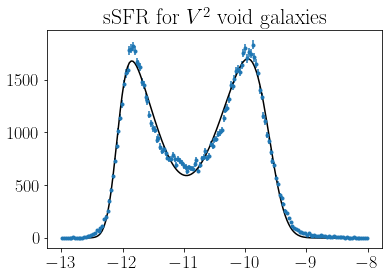

[ 1.80217189e+03 -9.62480234e+00  7.01419468e-01 -3.04960933e+00
  1.34375470e+03 -1.20872218e+01  5.62942219e-01  4.02299214e+00] [2.43145365e+01 7.72014931e-03 1.87851413e-02 1.97208517e-01
 2.32241389e+01 5.09023827e-03 1.50137619e-02 2.70391390e-01]


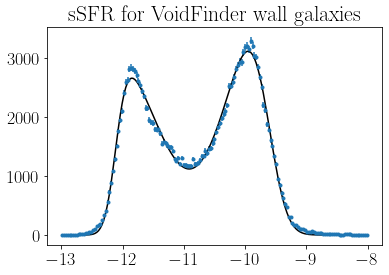

[ 3.11602684e+03 -9.62829772e+00  6.35265217e-01 -2.51565115e+00
  2.50437208e+03 -1.21111248e+01  6.74260141e-01  4.60370869e+00] [3.64677698e+01 6.54999846e-03 1.47710218e-02 1.32464541e-01
 3.67048365e+01 4.18246998e-03 1.53311700e-02 2.47184162e-01]


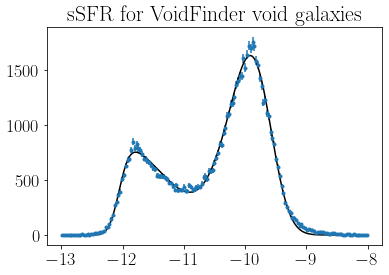

[ 1.46645695e+03 -9.63005965e+00  5.21611439e-01 -1.79463766e+00
  8.00659553e+02 -1.20547533e+01  7.79850678e-01  5.80919620e+00] [1.63316410e+01 8.03592375e-03 1.26685895e-02 1.05322355e-01
 1.71593883e+01 6.17262690e-03 2.59861372e-02 4.83127559e-01]


In [27]:
# a, mua, sga, askew, b, mub, sgb, bskew

#print("wall_v2")
k = bin_data(sSFR[wall_v2], bins_=np.linspace(-13,-8, 170))
x, poiss_err = k[0], k[2]
sSFR_V2_wall_fit = fit_bimodal(char_=sSFR,
                               class_=wall_v2,
                               bins=np.linspace(-13,-8, 170), 
                               err=poiss_err,
                               p0_=[1800, -9.6, 0.7, -3, 1300, -12.1, 0.6, 4], 
                               label='sSFR for $V^2$ wall galaxies')


#print("\n void_v2")
k = bin_data(sSFR[void_v2], bins_=np.linspace(-13,-8, 170))
x, poiss_err = k[0], k[2]
sSFR_V2_void_fit = fit_bimodal(char_=sSFR,
                               class_=void_v2,
                               bins=np.linspace(-13,-8, 170), 
                               err=poiss_err,
                               p0_=[2000, -9.8, 1.3, 1, 2000, -11.9, 1, 1], 
                               label='sSFR for $V^2$ void galaxies')


#print("\n wall_vf")
k = bin_data(sSFR[wall_vf], bins_=np.linspace(-13,-8, 170))
x, poiss_err = k[0], k[2]
sSFR_VF_wall_fit = fit_bimodal(char_=sSFR,
                               class_=wall_vf,
                               bins=np.linspace(-13,-8, 170), 
                               err=poiss_err,
                               p0_=[ 2000,  -9.8,  1.3, 1,2000,-11.5,1,1], 
                               label='sSFR for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(sSFR[void_vf], bins_=np.linspace(-13,-8, 170))
x, poiss_err = k[0], k[2]
sSFR_VF_void_fit = fit_bimodal(char_=sSFR,
                               class_=void_vf,
                               bins=np.linspace(-13,-8, 170), 
                               err=poiss_err,
                               p0_=[ 2000,  -9.8,  1.3, 1,2000,-11.5,1,1], 
                               label='sSFR for VoidFinder void galaxies')

# Extract the mean and the error in the mean from the fit results

### Calculate averages and medians

In [31]:
def remove_nan(array):
    '''
    Remove both nan and inf values from array
    '''
    #return array[np.logical_not(np.isnan(array))]
    return array[np.isfinite(array)]

In [29]:
def stat(char_, voidfinder=False):
    '''
    PARAMETERS
    ==========
    char_ : 
        array with galaxy properties, e.g., Mstar
    
    voidfinder : boolean
        True if we want to calculate the statistics of VoidFinder data and not V2 data
    
    
    note 1 : shifts are taken as (void - wall)
    
    note 2 : percent difference are calculated with respect to the wall distribution
    
    
    RETURNS
    =======
    average
    std of average
    average shift
    std of average shift
    percent diff of avg
    median
    median shift
    percent diff of median
    '''
    
    if voidfinder:
        char_void = remove_nan(char_[void_vf])
        char_wall = remove_nan(char_[wall_vf])
        
    else:
        char_void = remove_nan(char_[void_v2])
        char_wall = remove_nan(char_[wall_v2])
        
    avg_void = np.mean(char_void)
    avg_wall = np.mean(char_wall)
        
    avg_shift = avg_wall-avg_void
        
    std_avg_void = np.std(char_void, ddof=1)/np.sqrt(len(char_void))
    std_avg_wall = np.std(char_wall, ddof=1)/np.sqrt(len(char_wall))
    
    std_avg_shift = np.sqrt(std_avg_void**2 + std_avg_wall**2)
        
    percent_diff_avg = (avg_shift/avg_wall)*100
    
    median_wall = np.median(char_wall)
    median_void = np.median(char_void)
    
    median_shift = median_wall-median_void
    
    percent_diff_median = (median_shift/median_wall)*100
    
    mode_wall = stats.mode(char_wall, axis=None)[0][0]
    mode_void = stats.mode(char_void, axis=None)[0][0]
    
    mode_shift = mode_wall-mode_void
    percent_diff_mode = (mode_shift/mode_wall)*100
    
    print('average void : %.3f \pm %.3f' %(avg_void, std_avg_void))
    print('median void : %.3f' %median_void)
    print('average shift w.r.t wall :  %.3f \pm %.3f'%(avg_shift, std_avg_shift))
    print('percent difference in avg w.r.t wall : %.3f percent' %(percent_diff_avg))
    print('median shift w.r.t wall: %.3f' %median_shift)
    print('percent difference in median w.r.t wall : %.3f percent' %percent_diff_median)
    print("\n")
    print('average wall :  %.3f \pm %.3f'%(avg_wall, std_avg_wall))
    print('median wall : %.3f' %median_wall)
    print("\n")
    
#     print('mode void : ', mode_void)
#     print('mode wall : ', mode_wall)
#     print('percent difference in mode w.r.t wall : ', percent_diff_mode)

In [32]:
print("\t \tStellar Mass \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(Mstar_NSA, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(Mstar_NSA)
print("----------------------------------------------- \n")

print("\t \tu-r \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(u_r_NSA, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(u_r_NSA)
print("----------------------------------------------- \n")

print("\t \tg-r \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(g_r_NSA, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(g_r_NSA)
print("----------------------------------------------- \n")

print("\t \tAbsolute Magnitude \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(rabsmag_NSA, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(rabsmag_NSA)
print("----------------------------------------------- \n")

print("\t \tStar formation Rate \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(SFR, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(SFR)
print("----------------------------------------------- \n")

print("\t \tSpecific Star Formation Rate \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(sSFR, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(sSFR)
print("----------------------------------------------- \n")

	 	Stellar Mass 

--------------------VOIDFINDER--------------------------- 

average void : 9.792 \pm 0.002
median void : 9.915
average shift w.r.t wall :  0.147 \pm 0.002
percent difference in avg w.r.t wall : 1.476 percent
median shift w.r.t wall: 0.101
percent difference in median w.r.t wall : 1.007 percent


average wall :  9.939 \pm 0.001
median wall : 10.016



----------------------V2------------------------- 

average void : 10.049 \pm 0.002
median void : 10.178
average shift w.r.t wall :  0.004 \pm 0.003
percent difference in avg w.r.t wall : 0.041 percent
median shift w.r.t wall: -0.003
percent difference in median w.r.t wall : -0.026 percent


average wall :  10.054 \pm 0.002
median wall : 10.176


----------------------------------------------- 

	 	u-r 

--------------------VOIDFINDER--------------------------- 

average void : 1.965 \pm 0.002
median void : 1.920
average shift w.r.t wall :  0.162 \pm 0.002
percent difference in avg w.r.t wall : 7.612 percent
median shift 

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_1837/2997052487.py:60: RuntimeWarning: invalid value encountered in double_scalars
  percent_diff_mode = (mode_shift/mode_wall)*100


average void : -19.630 \pm 0.004
median void : -19.845
average shift w.r.t wall :  -0.229 \pm 0.005
percent difference in avg w.r.t wall : 1.155 percent
median shift w.r.t wall: -0.115
percent difference in median w.r.t wall : 0.576 percent


average wall :  -19.860 \pm 0.002
median wall : -19.960



----------------------V2------------------------- 

average void : -20.132 \pm 0.004
median void : -20.368
average shift w.r.t wall :  -0.009 \pm 0.006
percent difference in avg w.r.t wall : 0.044 percent
median shift w.r.t wall: 0.007
percent difference in median w.r.t wall : -0.036 percent


average wall :  -20.141 \pm 0.005
median wall : -20.361


----------------------------------------------- 

	 	Star formation Rate 

--------------------VOIDFINDER--------------------------- 

average void : -0.302 \pm 0.002
median void : -0.215
average shift w.r.t wall :  -0.132 \pm 0.003
percent difference in avg w.r.t wall : 30.455 percent
median shift w.r.t wall: -0.200
percent difference in medi